In [ ]:
# Import av bibliotek

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split



In [ ]:
# importerer de to json filene -> gjør de til pandas dataframes -> kobler de sammen på dato -> 
# flatterer de ut -> konverterer dato til datetime format


with open("../data/analyzed_data/frostAPI_analyzed_data.json", "r", encoding="utf-8") as file:
    frost_data = json.load(file)


frost_df = pd.json_normalize(frost_data)

with open("../data/analyzed_data/niluAPI_analyzed_data.json", "r", encoding="utf-8") as file:
    nilu_data = json.load(file)

nilu_df = pd.json_normalize(nilu_data)


df_combined = pd.merge(frost_df, nilu_df, on='Dato', how='inner')

df_combined['Dato'] = pd.to_datetime(df_combined['Dato']) 


print(df_combined.head(5))

print(df_combined.isna().sum()) #dobbeltsjekker at det ikke er NaN verdier

data=df_combined 

        Dato    Nedbør  Temperatur  Vindhastighet  Interpolert_Nedbør  \
0 2010-04-02  1.623594   -0.532196       0.202134               False   
1 2010-04-03  1.266981   -0.582540      -0.341967               False   
2 2010-04-04 -0.818619   -0.418925       0.836919               False   
3 2010-04-05 -0.818619   -0.142038      -0.251284               False   
4 2010-04-06 -0.818619   -0.507025      -1.067436               False   

   Interpolert_Temperatur  Interpolert_Vindhastighet  Dekningsgrad_NO2  \
0                   False                      False             100.0   
1                   False                      False             100.0   
2                   False                      False             100.0   
3                   False                      False             100.0   
4                   False                      False             100.0   

   Dekningsgrad_O3  Dekningsgrad_SO2  Verdi_NO2_Trans  Verdi_O3_Trans  \
0            100.0             100.0       


Verdi_NO2_Trans:
Koeffisient: -0.4861
Intercept: -0.0001
R² score: 0.2362
Mean Squared Error: 0.7641


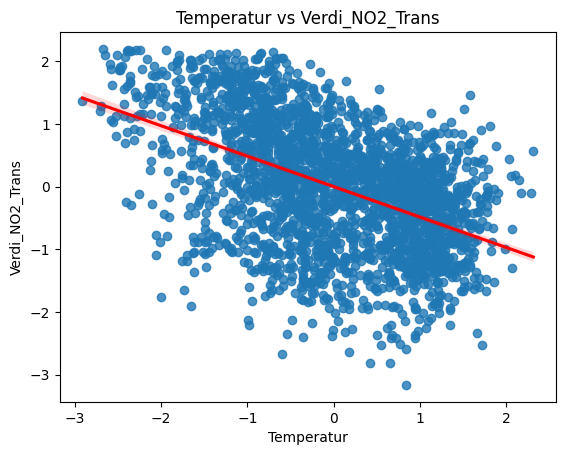


Verdi_SO2_Trans:
Koeffisient: -0.3378
Intercept: 0.0002
R² score: 0.1141
Mean Squared Error: 0.8862


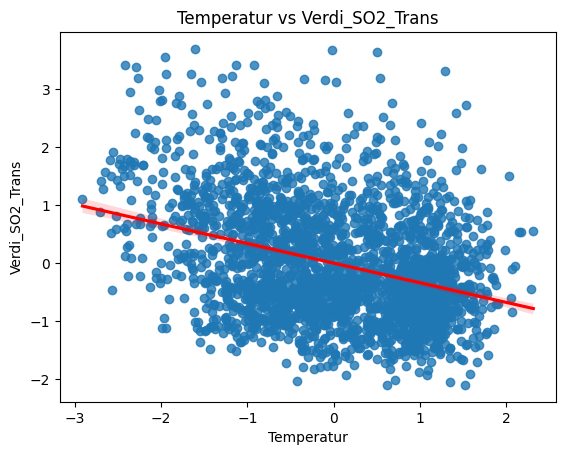


Verdi_O3_Trans:
Koeffisient: 0.3151
Intercept: 0.0009
R² score: 0.0994
Mean Squared Error: 0.8992


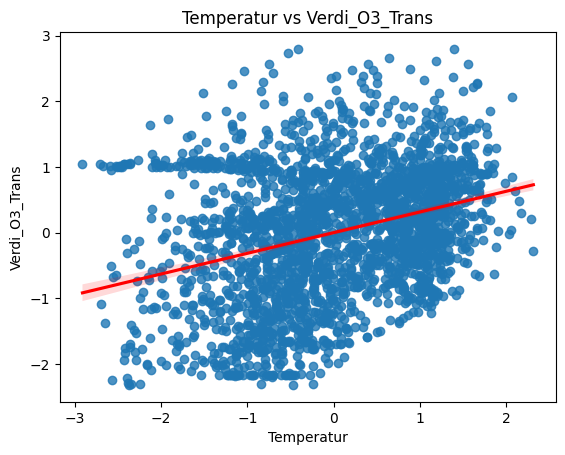

In [ ]:

"""
Enkelt lineær regresjon med temperatur som forklaringsvariabel
Vi starter med å se hvordan temperaturen alene påvirker hver av gassene (NO2, SO2, O3).
"""

for target in ["Verdi_NO2_Trans", "Verdi_SO2_Trans", "Verdi_O3_Trans"]:
    X = data[["Temperatur"]]
    y = data[target]

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    print(f"\n{target}:")
    print(f"Koeffisient: {model.coef_[0]:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R² score: {r2_score(y, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y, y_pred):.4f}")

    # Visualisering
    sns.regplot(x=X["Temperatur"], y=y, line_kws={"color": "red"})
    plt.title(f"Temperatur vs {target}")
    plt.xlabel("Temperatur")
    plt.ylabel(target)
    plt.show()


### Enkel regresjon med én værvariabel (Tempratur)

- **NO₂ (Verdi_NO2_Trans)**:  
  - Koeffisient: -0.49  
  - R²: **0.24** → ca. 24 % av variasjonen forklares  
  - MSE: 0.76

- **SO₂ (Verdi_SO2_Trans)**:  
  - Koeffisient: -0.34  
  - R²: **0.11** → svak forklaringskraft  
  - MSE: 0.89

- **O₃ (Verdi_O3_Trans)**:  
  - Koeffisient: +0.32  
  - R²: **0.10** → svært liten forklaringskraft  
  - MSE: 0.90

> Konklusjon: Temperatur har størst betydning for NO₂, men ingen av modellene gir sterk presisjon alene.



Multippel regresjon for Verdi_NO2_Trans:
Koeffisienter: {'Temperatur': np.float64(-0.4354522222797651), 'Vindhastighet': np.float64(-0.5281277050237194), 'Nedbør': np.float64(-0.06146296217261188)}
Intercept: -0.0001
R² score: 0.5255
Mean Squared Error: 0.4747


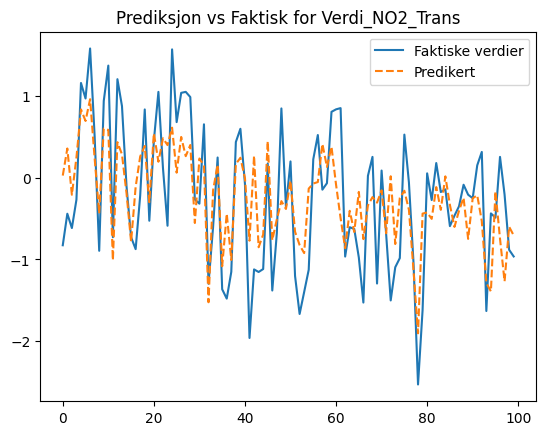


Multippel regresjon for Verdi_SO2_Trans:
Koeffisienter: {'Temperatur': np.float64(-0.30812906508521953), 'Vindhastighet': np.float64(-0.28985095132749106), 'Nedbør': np.float64(-0.06069796524963838)}
Intercept: 0.0002
R² score: 0.2059
Mean Squared Error: 0.7944


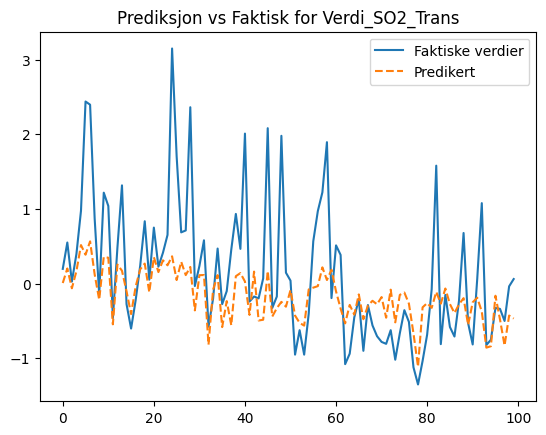


Multippel regresjon for Verdi_O3_Trans:
Koeffisienter: {'Temperatur': np.float64(0.2919097136069179), 'Vindhastighet': np.float64(0.30820030406899246), 'Nedbør': np.float64(-0.05514881571262055)}
Intercept: 0.0009
R² score: 0.1922
Mean Squared Error: 0.8066


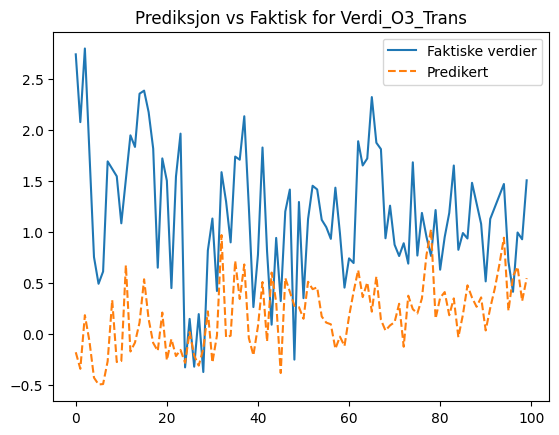

In [ ]:

"""
Multippel lineær regresjon
Vi bruker temperatur, vind og nedbør samlet for å forutsi hver gass.
"""

features = ["Temperatur", "Vindhastighet", "Nedbør"]

for target in ["Verdi_NO2_Trans", "Verdi_SO2_Trans", "Verdi_O3_Trans"]:
    X = data[features]
    y = data[target]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    print(f"\nMultippel regresjon for {target}:")
    print("Koeffisienter:", dict(zip(features, model.coef_)))
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R² score: {r2_score(y, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y, y_pred):.4f}")

    # Visualisering
    plt.plot(y.values[:100], label="Faktiske verdier")
    plt.plot(y_pred[:100], label="Predikert", linestyle="--")
    plt.title(f"Prediksjon vs Faktisk for {target}")
    plt.legend()
    plt.show()


### Resultater fra multippel regresjon

- **NO₂ (Verdi_NO2_Trans)**: Best forklaringskraft. Negativ sammenheng med temperatur, vind og nedbør.  
  - R²: **0.53**, MSE: **0.47**

- **SO₂ (Verdi_SO2_Trans)**: Lavere forklaringskraft. Alle faktorer påvirker negativt.  
  - R²: **0.21**, MSE: **0.79**

- **O₃ (Verdi_O3_Trans)**: Svakest forklaringskraft. Positivt påvirket av temperatur og vind, negativt av nedbør.  
  - R²: **0.19**, MSE: **0.81**

> NO₂ er mest forutsigbar basert på værvariabler. O₃ og SO₂ krever trolig flere forklaringsfaktorer.



Multippel regresjon for Verdi_NO2_Trans:
Koeffisienter: {'Temperatur': np.float64(-0.3286549174028879), 'Vindhastighet': np.float64(-0.423943656091781), 'Nedbør': np.float64(-0.052901261270740296), 'Verdi_SO2_Trans': np.float64(0.2416790410166368), 'Verdi_O3_Trans': np.float64(-0.11074988741643067)}
Intercept: -0.0000
R² score: 0.5794
Mean Squared Error: 0.4207


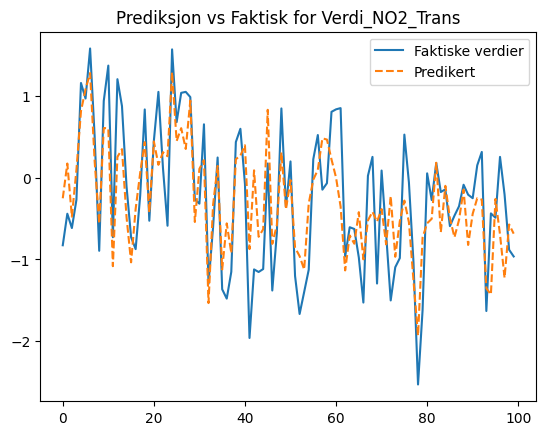

In [30]:
"""
Multippel lineær regresjon
Vi bruker temperatur, vind, nedbør, samt SO2 og O3 for å forutsi NO2.
"""

features = ["Temperatur", "Vindhastighet", "Nedbør", "Verdi_SO2_Trans", "Verdi_O3_Trans"]

for target in ["Verdi_NO2_Trans"]:
    X = data[features]
    y = data[target]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    print(f"\nMultippel regresjon for {target}:")
    print("Koeffisienter:", dict(zip(features, model.coef_)))
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R² score: {r2_score(y, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y, y_pred):.4f}")

    # Visualisering
    plt.plot(y.values[:100], label="Faktiske verdier")
    plt.plot(y_pred[:100], label="Predikert", linestyle="--")
    plt.title(f"Prediksjon vs Faktisk for {target}")
    plt.legend()
    plt.show()


Når R²-scoren økte etter å ha lagt til de to andre gassene (Verdi_SO2_Trans og Verdi_O3_Trans) i den multivariate regresjonsmodellen, betyr det at disse variablene bidro med nyttig informasjon for å forklare variasjonen i den avhengige variabelen (Verdi_NO2_Trans). Med andre ord, inkluderingen av SO2- og O3-data forbedret modellens prediksjonsevne, og gjorde at modellen kunne forklare en større del av variasjonen i NO2-gassens konsentrasjon. Dette kan indikere at forholdet mellom gassene har noe innvirkning på NO2-nivåene.

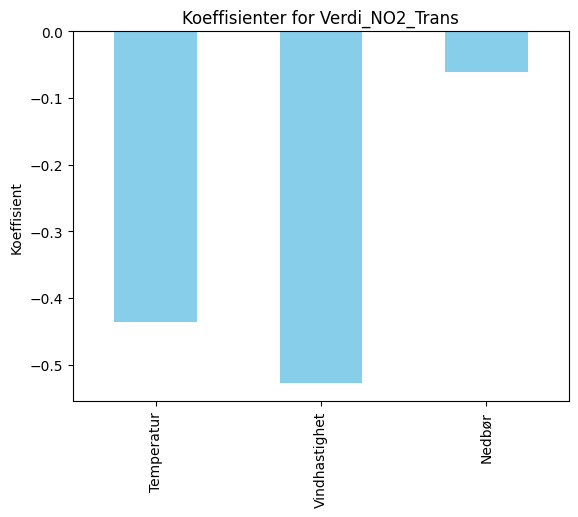

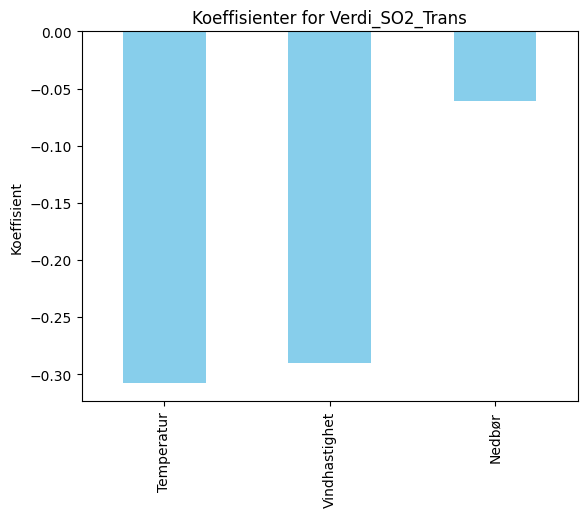

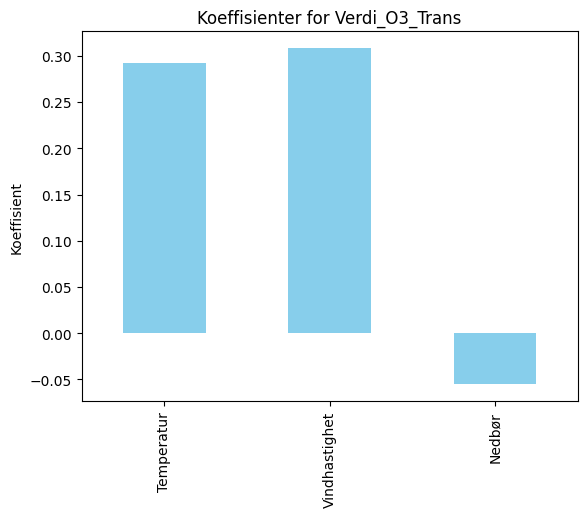

In [ ]:

"""
Stolpediagram over koeffisienter (feature importance)
Viser hvilke variabler som har størst effekt på hver gass.
"""

for target in ["Verdi_NO2_Trans", "Verdi_SO2_Trans", "Verdi_O3_Trans"]:
    X = data[features]
    y = data[target]
    model = LinearRegression().fit(X, y)

    coeffs = pd.Series(model.coef_, index=features)
    coeffs.plot(kind='bar', title=f"Koeffisienter for {target}", color='skyblue')
    plt.ylabel("Koeffisient")
    plt.show()

### Sammenheng mellom vær og luftkvalitet

Analysen viser at **nedbør har svært liten påvirkning** på nivåene av NO₂, SO₂ og O₃. Dette gjenspeiles i de lave koeffisientene og forklaringsgraden (R²). Derimot har **vind og temperatur større innvirkning**, spesielt på NO₂:

- **Vindhastighet har negativ sammenheng**, noe som kan tyde på at økt vind bidrar til å spre gassene og dermed redusere konsentrasjonen lokalt.
- **Temperatur påvirker kjemiske reaksjoner** og gassers bevegelse, og har også en negativ sammenheng for NO₂ og SO₂.

Vi ser **noe sammenheng mellom vær og NO₂**, men **svakere sammenheng for SO₂ og nesten ingen for O₃**. En mulig forklaring er at **NO₂ ofte kommer fra lokale kilder** som biltrafikk, som i større grad påvirkes av kortsiktig vær, mens O₃ og SO₂ også påvirkes av regionale og kjemiske forhold som ikke fanges opp av de enkle værvariablene.



Verdi_O3_Trans:
Koeffisient: -0.3887
Intercept: 0.0008
R² score: 0.1514
Mean Squared Error: 0.8473


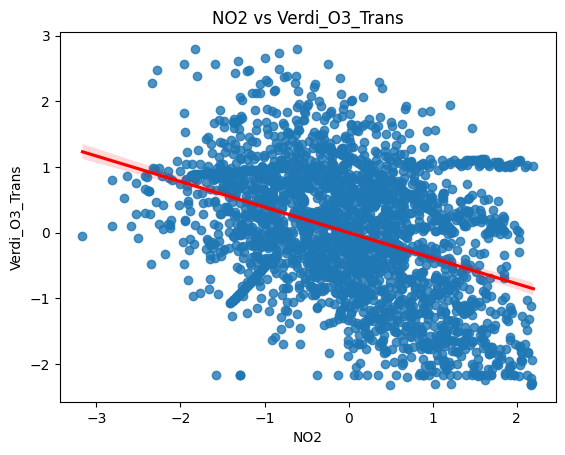


Verdi_SO2_Trans:
Koeffisient: 0.5137
Intercept: 0.0002
R² score: 0.2639
Mean Squared Error: 0.7364


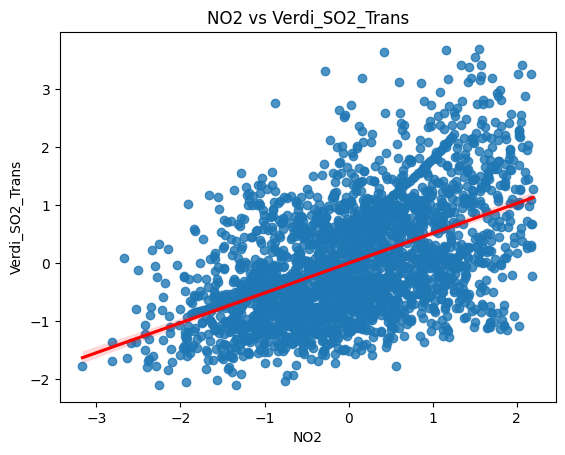

In [ ]:

for target in ["Verdi_O3_Trans", "Verdi_SO2_Trans"]:
    X = data[["Verdi_NO2_Trans"]]
    y = data[target]

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    print(f"\n{target}:")
    print(f"Koeffisient: {model.coef_[0]:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R² score: {r2_score(y, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y, y_pred):.4f}")

    # Visualisering
    sns.regplot(x=X["Verdi_NO2_Trans"], y=y, line_kws={"color": "red"})
    plt.title(f"NO2 vs {target}")
    plt.xlabel("NO2")
    plt.ylabel(target)
    plt.show()


Her ser vi at det er relativ sammenheng mellom de ulike gassene med liten R² score.

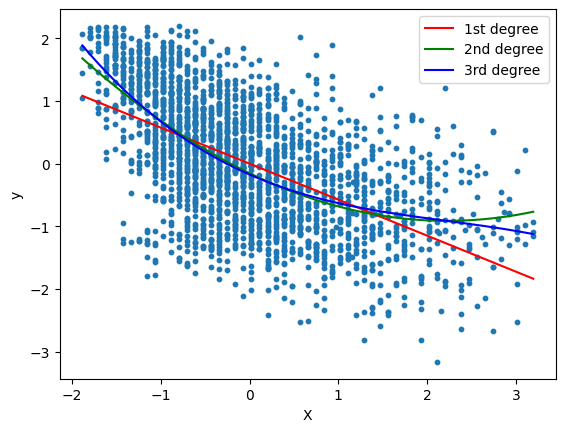

R² score for 1st degree polynomial: 0.3306
R² score for 2nd degree polynomial: 0.3685
R² score for 3rd degree polynomial: 0.3709


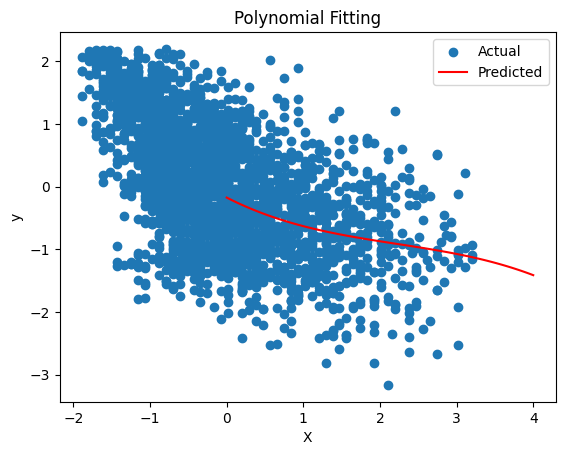

In [28]:

#lag modell
def create_model(X, y, deg):
    polynom_deg = np.polyfit(X, y, deg=deg)
    my_model = np.poly1d(polynom_deg)
    return my_model


X = data[ "Vindhastighet"]  
y = data["Verdi_NO2_Trans"]  


my_model_1 = create_model(X, y, 1)
my_model_2 = create_model(X, y, 2)
my_model_3 = create_model(X, y, 3)


plt.scatter(X, y, s=10)
X_sorted = np.sort(X)
y_1 = my_model_1(X_sorted)
y_2 = my_model_2(X_sorted)
y_3 = my_model_3(X_sorted)

plt.plot(X_sorted, y_1, color='r', label='1st degree')
plt.plot(X_sorted, y_2, color='g', label='2nd degree')
plt.plot(X_sorted, y_3, color='b', label='3rd degree')

plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


r2_1 = r2_score(y, my_model_1(X))
r2_2 = r2_score(y, my_model_2(X))
r2_3 = r2_score(y, my_model_3(X))

print(f"R² score for 1st degree polynomial: {r2_1:.4f}")
print(f"R² score for 2nd degree polynomial: {r2_2:.4f}")
print(f"R² score for 3rd degree polynomial: {r2_3:.4f}")


test_X = np.linspace(0, 4, 100)
y_predict = my_model_3(test_X)

# Plot
plt.scatter(X, y, label='Actual')
plt.plot(test_X, y_predict, color='red', label='Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Polynomial Fitting')
plt.legend()
plt.show()


Her prøver vi en ny modell(Polynomial regression) for å se om vi ser noe sammenheng mellom vind og NO2 gass. Vi ser en liten sammenheng her, men fortsatt veldig svak. Størst sammenheng på modell 3.